In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
os.chdir("/home/havb/data/climate/")

In [3]:
temp = xr.open_dataset("tas_ccsm4.nc")

In [4]:
BA_data = temp.sel(lat = -34.603722, lon = 360 - 58.381592, method = "nearest")

In [5]:
df = BA_data.tas.to_dataframe()

In [6]:
file="BA_temp.csv"
df.to_csv(file,index=True,header=True, index_col='time')
# To read it later: df = pd.read_csv(file, parse_dates='time', index_col='time')

In [7]:
df.head()

,lon,lat,tas
time,,,
1850-01-16 12:00:00,301.25,-34.397906,296.392029
1850-02-15 00:00:00,301.25,-34.397906,296.123444
1850-03-16 12:00:00,301.25,-34.397906,295.638092
1850-04-16 00:00:00,301.25,-34.397906,289.784698
1850-05-16 12:00:00,301.25,-34.397906,285.384766


In [8]:
df.dtypes

lon    float64
lat    float64
tas    float64
dtype: object

In [9]:
df.index

DatetimeIndex(['1850-01-16 12:00:00', '1850-02-15 00:00:00',
               '1850-03-16 12:00:00', '1850-04-16 00:00:00',
               '1850-05-16 12:00:00', '1850-06-16 00:00:00',
               '1850-07-16 12:00:00', '1850-08-16 12:00:00',
               '1850-09-16 00:00:00', '1850-10-16 12:00:00',
               ...
               '2100-03-16 12:00:00', '2100-04-16 00:00:00',
               '2100-05-16 12:00:00', '2100-06-16 00:00:00',
               '2100-07-16 12:00:00', '2100-08-16 12:00:00',
               '2100-09-16 00:00:00', '2100-10-16 12:00:00',
               '2100-11-16 00:00:00', '2100-12-16 12:00:00'],
              dtype='datetime64[ns]', name=u'time', length=3012, freq=None)

In [10]:
# Transform from Kelvin to Celsius
df.tas = df.tas - 273

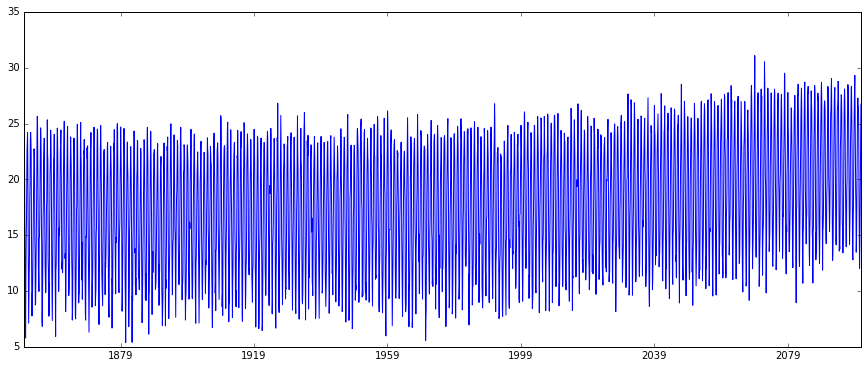

In [11]:
plt.plot(df["tas"])

In [12]:
df.tas.mean()

17.701059237577685

In [13]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #%%
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

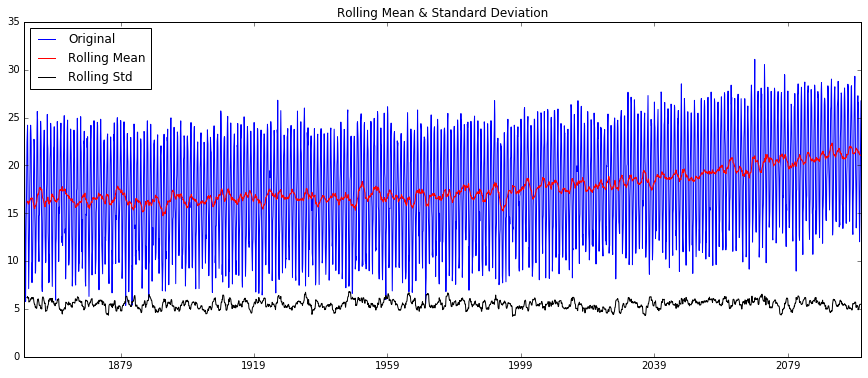

Results of Dickey-Fuller Test:
Test Statistic                   -2.034212
p-value                           0.271777
#Lags Used                       28.000000
Number of Observations Used    2983.000000
Critical Value (5%)              -2.862509
Critical Value (1%)              -3.432544
Critical Value (10%)             -2.567286
dtype: float64


In [14]:
test_stationarity(df.tas)

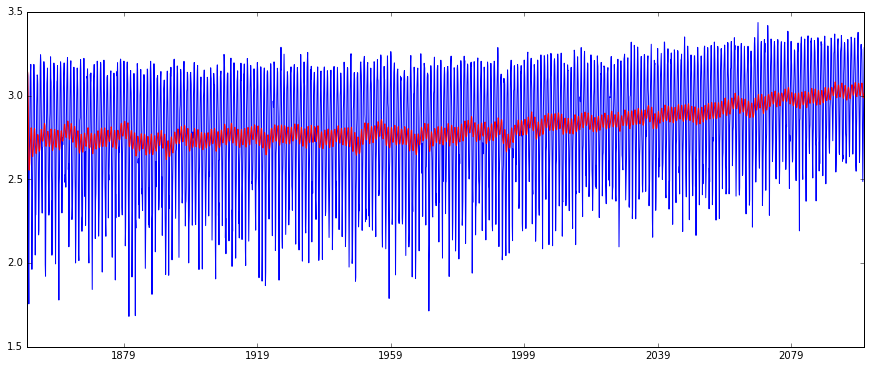

In [69]:
# Exponentiate TS
ts_log = np.log(df.tas)

# Calculate decaying weighted moving average
expwighted_avg = ts_log.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()

# Plot
plt.plot(ts_log, color='blue')
plt.plot(expwighted_avg, color='red')

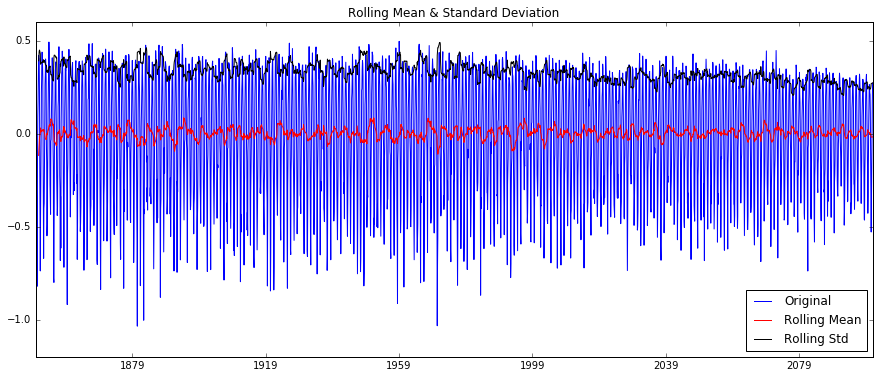

Results of Dickey-Fuller Test:
Test Statistic                -1.268763e+01
p-value                        1.150435e-23
#Lags Used                     2.900000e+01
Number of Observations Used    2.982000e+03
Critical Value (5%)           -2.862510e+00
Critical Value (1%)           -3.432545e+00
Critical Value (10%)          -2.567286e+00
dtype: float64


In [35]:
# Substract weighted MA from time series
ts_log_moving_avg_diff = ts_log - expwighted_avg

test_stationarity(ts_log_moving_avg_diff)


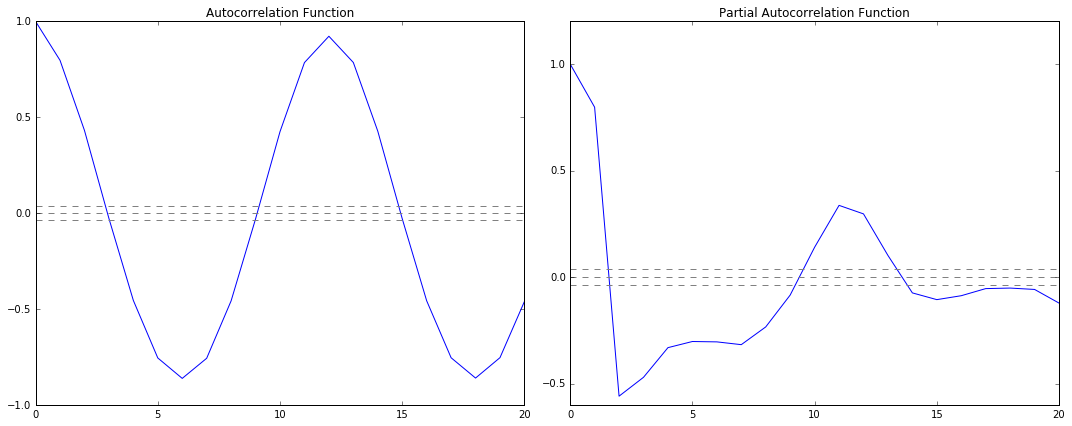

In [36]:
# ARIMA modeling

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_moving_avg_diff, nlags=20)
lag_pacf = pacf(ts_log_moving_avg_diff, nlags=20, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

__The ACF plot suggests a MA(3) process, as the the third lag s the first to cross the confidence interval. The PACF plot points to a AR(2) proces, as now is the second lag the first one to cross the confidence interval.__

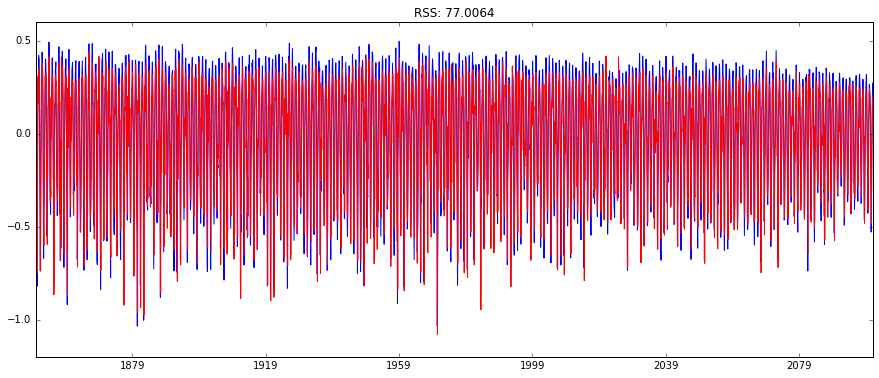

In [84]:
from statsmodels.tsa.arima_model import ARIMA

# AR(2)I(0)
model = ARIMA(ts_log_moving_avg_diff, order=(2, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_moving_avg_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_moving_avg_diff)**2))

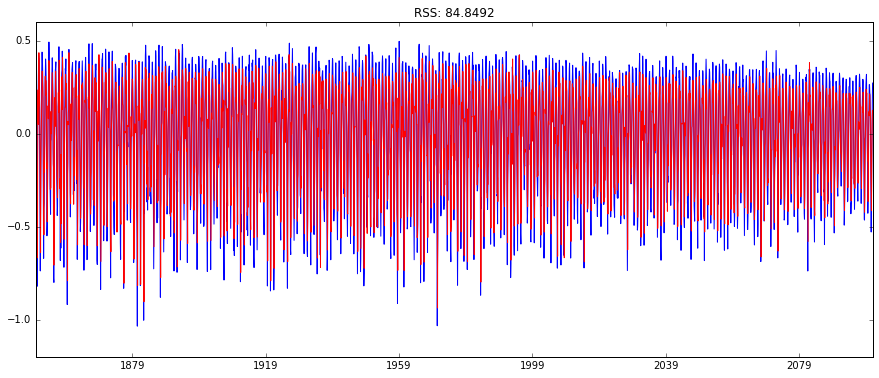

In [85]:
model = ARIMA(ts_log_moving_avg_diff, order=(0, 0, 3))  

#I(0)MA(3)
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_moving_avg_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_moving_avg_diff)**2))

/home/havb/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


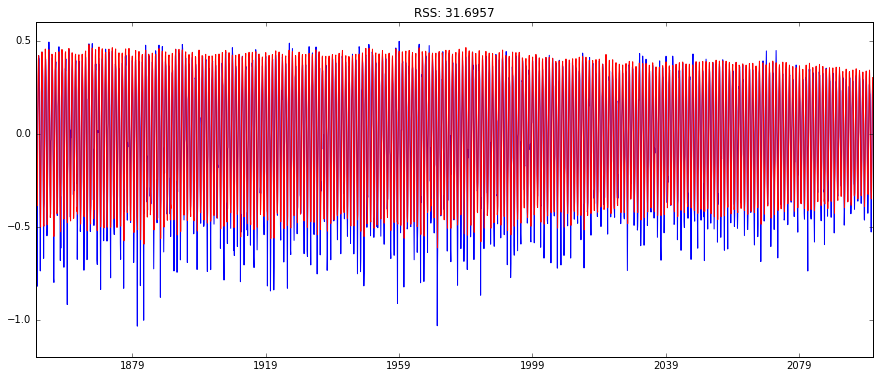

In [86]:
# AR(2)I(0)MA(3)

model = ARIMA(ts_log_moving_avg_diff, order=(2, 0, 3))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_moving_avg_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_moving_avg_diff)**2))